In [1]:
#!sudo pip3 install pyro-ppl -q
import pyro.distributions as dist
from pyro import plate
from pyro.distributions import Categorical
import pyro
import torch.nn as nn
import torch
import torch.distributions.constraints as constraints
import pyro.optim as optim
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from spotlight.evaluation import sequence_mrr_score
import matplotlib.pyplot as plt
import numpy as np

import utils
import lstmRecTricov
import preproc
device = utils.get_device("cuda")

In [2]:
dataset = "rsc"
dat, dat_seq, ind2val = preproc.preprocess_data(dataset, device)

START load data
Loaded train set
	Events: 3164513
	Sessions: 796626
	Items: 31882
	Span: 2014-04-01 / 2014-09-29

Loaded test set
	Events: 7299
	Sessions: 1532
	Items: 1705
	Span: 2014-09-29 / 2014-09-30

END load data  1.9352889999999991 c /  1.930995225906372 s


## MODEL

In [3]:
import pyro
import torch.nn as nn
import torch
import torch.distributions.constraints as constraints
import pyro.distributions as dist
from pyro import plate
from pyro.distributions import Categorical


class LSTMrec(nn.Module):
    def __init__(self, num_items, emb_dim, batch_size, num_negsamples, device):
        super(LSTMrec, self).__init__()
        self.batch_size = batch_size
        self.num_items = num_items
        self.emb_dim = emb_dim
        self.num_negsamples = num_negsamples # When training, how many negative examples should be sampled
        
        ### CUDA
        self.device = device
        
        # PRIORS
        self.tri0 = torch.cholesky(torch.diag(torch.ones(self.emb_dim).to(self.device)*5))
        
        # ITEM EMB
        self.V = nn.Embedding(embedding_dim= self.emb_dim,
                                           num_embeddings = self.num_items)
        
        ### LSTM
        self.linear = nn.Linear(1,1) #nn.ModuleList(nn.Parameter(torch.zeros((1,))))
        self.lstm = nn.LSTM(batch_first=True,
                                input_size=self.emb_dim,
                                hidden_size=self.emb_dim)
        
        # Need to permute before and after LSTM because LSTM's batch_first is not supported...
        self.permute_for_lstm = lambda x: x.permute(1,0,2)
        self.permute_back_lstm = lambda x: x.permute(1,0,2)
        
        if device.type == "cuda":
            self.cuda()    
            
    def predict(self, seq, bs = 50):
        """A minibatch version of forward"""
        preds = []
        for i in range(0, len(seq), bs):
            pred_batch = self.forward(seq[i:(i+bs)])
            preds.append(pred_batch)
        preds = torch.cat(preds, dim = 0)
        return preds
    
    def forward(self, seq, targets = None):
        """
        seq: a torch array with dimension (batch_size, sequence length).
        Needs to be long() and on right device. 
        
        targets: (batch_size, time steps, probs)
        Outputs log probabilities of all items. (todo: Let user specify which items to calc)
        """
        seq = seq.to(self.device)
        x_vecs = self.V(seq)
        z, _ = self.lstm(x_vecs)
        z = z.unsqueeze(2) # unsqueeze to get a dimension for the different items from target.

        if targets is None:
            ## DEFAULT TO CHECKING ALL ITEMS HERE.. Need to build appropriate matrix...
            targets = torch.arange(end=self.num_items).repeat(seq.size() + (1,))
            
        target_vecs = self.V.weight[targets]

        dot = (z * target_vecs).sum(3) # sum vectors
        lprob = self.linear.bias + dot
        return lprob
    
    def model(self, seq):
        mu0 = torch.zeros(self.emb_dim).to(self.device)
        tri0 = self.tri0 # create this when initializing. (takes 4ms each time!)

        muV = pyro.sample("muV", dist.MultivariateNormal(loc = mu0, scale_tril=tri0))

        with plate("item_loop", self.num_items):
            V = pyro.sample(f"V", dist.MultivariateNormal(muV, scale_tril=tri0))

        # LIFT MODULE:
        prior = {'linear.bias' : dist.Normal(0,1),
                'V.weight' : Deterministic_distr(V)}
        with plate("lstm", self.num_items):
            lifted_module = pyro.random_module("net", self, prior= prior)
        

        lifted_reg_model = lifted_module()
        lifted_reg_model.lstm.flatten_parameters()

        with pyro.plate("data", len(seq), subsample_size = self.batch_size) as ind:
            batch_seq = seq[ind,]#.to(self.device)
            x = batch_seq[:,:-1]
            y = batch_seq[:,1:]
            batch_mask = (y!=0).float()

            # Build positive and negative examples:
            negs = torch.randint(high=self.num_items, size = y.size() + (self.num_negsamples,) ).to(device)
            candidates = torch.cat((y.unsqueeze(2), negs), dim = 2)
            lprob = lifted_reg_model(x, targets = candidates)
            data = pyro.sample("obs_x", 
                               dist.Categorical(logits=lprob).mask(batch_mask).to_event(2), 
                               obs = torch.zeros_like(y))
        return lifted_reg_model
    
    def guide(self, x):
                           
        bias_loc = pyro.param("bias_loc", torch.tensor(0.0).to(self.device))
        bias_scale = pyro.param("bias_scale", torch.tensor(2.0).to(self.device), constraint = constraints.positive)
        bias = dist.Normal(loc = bias_loc, scale = bias_scale)

        
        # GLOBAL V:
        muV_mean = pyro.param("muV_mean", torch.rand(self.emb_dim).to(self.device))
        global_triV = pyro.param("triangVpar", 
              torch.diag(0.5*torch.ones(self.emb_dim)).to(self.device), 
              constraint = constraints.lower_cholesky)
        muV = pyro.sample("muV", dist.MultivariateNormal(muV_mean, scale_tril=global_triV))
        
        ### ITEMS RVs ###
        # Each item has a factor it multiplies L with on diagonal. 
        # Inspiration: covar = L D L^t = (L D^0.5) (L D^0.5)ˆt
        # item_var is the D**2
        item_var = pyro.param("item_var_factor", (torch.rand(self.num_items)+0.5).to(self.device),
                              constraint = constraints.positive)
        D_V = (
            torch.diag(
                torch.ones(self.emb_dim)
                .to(self.device))
            .unsqueeze(0)
            .repeat(len(item_var),1,1)
            *item_var.unsqueeze(1)
            .unsqueeze(1)
        )
        triV = global_triV.matmul(D_V)

        V = pyro.param("Vpar", torch.rand(self.num_items, self.emb_dim).to(self.device)-0.5)

        ## item latent vectors
        with plate("item_loop", self.num_items) as i: # 
            V = pyro.sample(f"V", dist.MultivariateNormal(V[i,], scale_tril=triV[i,]))
            
        posterior = {'linear.bias' : bias,
                'V.weight' : Deterministic_distr(V)}
        
        lifted_module = pyro.random_module("net", self, prior = posterior)
        
        lifted_reg_model = lifted_module()
        lifted_reg_model.lstm.flatten_parameters()
        return lifted_reg_model

    
class Deterministic_distr(pyro.distributions.Distribution):
    def __init__(self, V):
        self.V = V
    def sample(self):
        return self.V
    def log_prob(self,x):
        return torch.zeros(x.size()[0])
    

In [4]:
## %%time
print("Initializing model")
pyro.clear_param_store()

batch_size = 900
epochs = 1000
num_recs = 10
steps_per_epoch = int(len(dat_seq['train'])/batch_size)
steps_per_epoch = int(steps_per_epoch/100)

seqrec = LSTMrec(len(ind2val['itemId'])+1, emb_dim = 5, batch_size = batch_size, num_negsamples = 100, device = device)
# set up the optimizer
adam_params = {"lr": 0.1}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(seqrec.model, seqrec.guide, optimizer, loss=Trace_ELBO())

Initializing model


In [5]:
%%time
print(f"Starting training {epochs} epochs, each with {steps_per_epoch} steps..")
for ep in range(epochs):
    for step in range(steps_per_epoch):
        loss = svi.step(dat_seq['train'])
        
    # COMPUTE ALL TYPES OF HITRATES...:
    with torch.no_grad():
        hitrate_train = utils.compute_bayesian_hitrate(seqrec, dat_seq['train_small'], num_recs = num_recs, num_samples=1, device = device)
        hitrate_test = utils.compute_bayesian_hitrate(seqrec, dat_seq['test'], num_recs = num_recs, num_samples=1, device = device)
        bayeshit_train = utils.compute_bayesian_hitrate(seqrec, dat_seq['train_small'], num_recs = num_recs, num_samples=3, device = device)
        bayeshit_test = utils.compute_bayesian_hitrate(seqrec, dat_seq['test'], num_recs = num_recs, num_samples=3, device = device)
        print(f"epoch: {ep} \t loss: {loss:.0f} \t TRAIN hitrate: freq/bayes: {hitrate_train:.3f} / {bayeshit_train:.3f}  \t TEST hitrate: freq/bayes: {hitrate_test:.3f} / {bayeshit_test:.3f}")
    

Starting training 1000 epochs, each with 9 steps..
epoch: 0 	 loss: 9377617042 	 TRAIN hitrate: freq/bayes: 0.010 / 0.014  	 TEST hitrate: freq/bayes: 0.005 / 0.002
epoch: 1 	 loss: 8585662841 	 TRAIN hitrate: freq/bayes: 0.024 / 0.023  	 TEST hitrate: freq/bayes: 0.006 / 0.006
epoch: 2 	 loss: 8063412513 	 TRAIN hitrate: freq/bayes: 0.025 / 0.027  	 TEST hitrate: freq/bayes: 0.004 / 0.004
epoch: 3 	 loss: 8184325150 	 TRAIN hitrate: freq/bayes: 0.026 / 0.026  	 TEST hitrate: freq/bayes: 0.005 / 0.004
epoch: 4 	 loss: 8115234438 	 TRAIN hitrate: freq/bayes: 0.026 / 0.027  	 TEST hitrate: freq/bayes: 0.005 / 0.007
epoch: 5 	 loss: 7655631941 	 TRAIN hitrate: freq/bayes: 0.024 / 0.025  	 TEST hitrate: freq/bayes: 0.007 / 0.005
epoch: 6 	 loss: 8108517755 	 TRAIN hitrate: freq/bayes: 0.029 / 0.030  	 TEST hitrate: freq/bayes: 0.006 / 0.006
epoch: 7 	 loss: 7550488320 	 TRAIN hitrate: freq/bayes: 0.031 / 0.030  	 TEST hitrate: freq/bayes: 0.006 / 0.007
epoch: 8 	 loss: 7439596428 	 TRAIN h

KeyboardInterrupt: 

## Variability in item factor over number of events on the item

Item activity/uncertainty correlation: -0.08
ALL ITEM ACTIVITY VS UNCERTAINTY FACTOR:


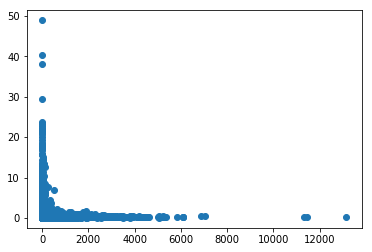

SMOOTHED AND ZOOMED ITEM ACTIVITY VS UNCERTAINTY FACTOR:


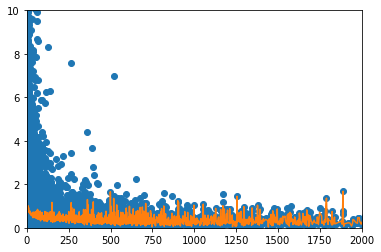

In [8]:
def get_counts(sequence, num):
    ids, id_count = np.unique(sequence, return_counts=True)
    counts = np.zeros(num)
    counts[ids] = id_count
    return counts

item_counts = get_counts(dat_seq['train'].cpu().numpy(), 1+len(ind2val['itemId']))[1:]
item_factors = pyro.param("item_var_factor").detach().cpu().numpy()[1:]
print(f"Item activity/uncertainty correlation: {np.corrcoef(item_factors, item_counts)[1,0]:.2f}")
print("ALL ITEM ACTIVITY VS UNCERTAINTY FACTOR:")
_ = plt.plot(item_counts, item_factors, "o")
plt.show()



print("SMOOTHED AND ZOOMED ITEM ACTIVITY VS UNCERTAINTY FACTOR:")
_ = plt.plot(item_counts, item_factors, "o")

import pandas as pd
item_variability = pd.DataFrame({'item_counts' : item_counts,
             'item_factors' : item_factors})
per_item_count = item_variability.groupby('item_counts')['item_factors'].mean().reset_index()
_ = plt.plot(per_item_count.item_counts, per_item_count.item_factors)
axes = plt.gca()
_ = axes.set_xlim([0,2000])
_ = axes.set_ylim([0,10])

## Plot distribution of items

tensor([[ 0.0006, -0.0001,  0.0004,  0.0020,  0.0011],
        [-0.0001,  0.0001, -0.0003, -0.0005, -0.0005],
        [ 0.0004, -0.0003,  0.0013,  0.0008,  0.0009],
        [ 0.0020, -0.0005,  0.0008,  0.0074,  0.0039],
        [ 0.0011, -0.0005,  0.0009,  0.0039,  0.0028]], device='cuda:0',
       grad_fn=<MmBackward>)


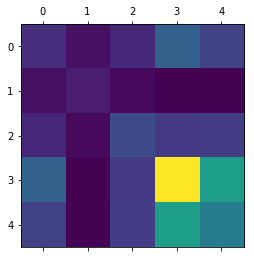

In [17]:
L = pyro.param("triangVpar")
print(L.matmul(L.t()))
plt.matshow(L.matmul(L.t()).detach().cpu().numpy())

Random items:


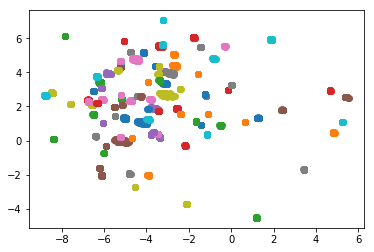

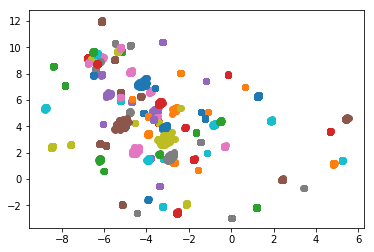

Most and least certain item: [ 2234 24614]


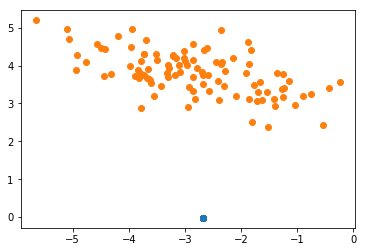

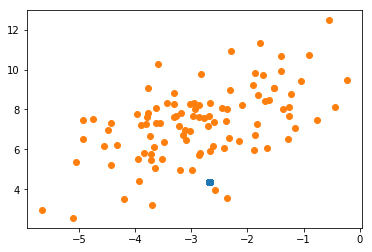

In [10]:
def plot_distr_of_items(items):
    sample_weights = []

    for _ in range(100):
        posterior_predictive = seqrec.guide(dat_seq['train_small'])
        sample_weights.append(posterior_predictive.V.weight[items,].unsqueeze(0))
    samples = torch.cat(sample_weights, dim = 0).cpu().detach().numpy()
    for u in range(len(items)):
        plt.plot(samples[:,u,0], samples[:,u,1], "o")
    plt.show()
    for u in range(len(items)):
        plt.plot(samples[:,u,0], samples[:,u,2], "o")
    plt.show()
    
print("Random items:")
items = torch.randint(low=1, high=len(ind2val['itemId']), size = (100,))
plot_distr_of_items(items)
plt.show()
items = np.array([pyro.param("item_var_factor").argmin().item(), pyro.param("item_var_factor").argmax().item()])
print("Most and least certain item:", items)
plot_distr_of_items(items)